<a href="https://colab.research.google.com/github/DhrubaPatra/-CrackYourPlacement-Challenge/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libaries

In [ ]:
!pip install tensorflow-text
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import keras
from keras.models import load_model
import pickle
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from transformers import TFXLNetModel, XLNetTokenizer
from tensorflow.keras.utils import plot_model
from transformers import BertTokenizer


# Utility Functions

In [ ]:
def plot_curves(hist,mapp):
  for i in mapp.keys():
    plt.plot(range(len(hist[i])),hist[i])
    plt.xlabel('Epochs')
    plt.ylabel(mapp[i])
    plt.show()

def create_model_xlnet(xlnet_model):
    word_inputs = tf.keras.Input(shape=(60,), name='word_inputs', dtype='int32')

    
    xlnet = TFXLNetModel.from_pretrained(xlnet_model)
    xlnet_encodings = xlnet(word_inputs)[0]

    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
     
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)

    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='binary_crossentropy', 
                  metrics=[keras.metrics.TruePositives(name='tp'),
                          keras.metrics.FalsePositives(name='fp'),
                          keras.metrics.TrueNegatives(name='tn'),
                          keras.metrics.FalseNegatives(name='fn'), 
                          keras.metrics.BinaryAccuracy(name='accuracy'),
                          keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall'),
                          keras.metrics.AUC(name='auc'),
                          keras.metrics.AUC(name='prc', curve='PR')])

    return model

def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  
    for i in range(len(data.Message)):
        encoded = tokenizer.encode_plus(data.Message[i],add_special_tokens=True,max_length=maximum_length,
                                        pad_to_max_length=True,return_attention_mask=True)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return np.array(input_ids),np.array(attention_masks)

# Load Dataset 

In [ ]:
train = '/content/drive/MyDrive/Projects/Superprof_Projects/Dhruba/trac2_eng_train.csv'
dev = '/content/drive/MyDrive/Projects/Superprof_Projects/Dhruba/trac2_eng_dev.csv'

train_data = pd.read_csv(train,sep=',', encoding='utf-8')
train_data.head()

test_data = pd.read_csv(dev,sep=',', encoding='utf-8')
test_data.head()

,ID,Text,Sub-task A,Sub-task B
0,C7.2589,U deserve more subscribers. U really great.,NAG,NGEN
1,C68.872,Nice video....,NAG,NGEN
2,C36.762,sorry if i bother somebody.. iam a defence asp...,NAG,GEN
3,C4.1540.1,Joker was amazing....it was not glamorised !.....,NAG,NGEN
4,C59.68,Nice baro,NAG,NGEN


# Data Preprocessing

In [ ]:
train_data.drop(['ID','Sub-task A'],axis=1,inplace=True)
train_data.rename(columns = {'Sub-task B':'Category', 'Text':'Message'}, inplace = True)
train_data.head()

test_data.drop(['ID','Sub-task A'],axis=1,inplace=True)
test_data.rename(columns = {'Sub-task B':'Category', 'Text':'Message'}, inplace = True)
test_data.head()

,Message,Category
0,U deserve more subscribers. U really great.,NGEN
1,Nice video....,NGEN
2,sorry if i bother somebody.. iam a defence asp...,GEN
3,Joker was amazing....it was not glamorised !.....,NGEN
4,Nice baro,NGEN


In [ ]:
train_data['Miso']=train_data['Category'].apply(lambda x: 1 if x=='GEN' else 0)
train_data.head()

test_data['Miso']=test_data['Category'].apply(lambda x: 1 if x=='GEN' else 0)
test_data.head()



,Message,Category,Miso
0,U deserve more subscribers. U really great.,NGEN,0
1,Nice video....,NGEN,0
2,sorry if i bother somebody.. iam a defence asp...,GEN,1
3,Joker was amazing....it was not glamorised !.....,NGEN,0
4,Nice baro,NGEN,0


In [ ]:
train_data['Miso'].value_counts()

0    3954
1     309
Name: Miso, dtype: int64

In [ ]:
# Class weights
class_weight = {0: 0.5390743550834598, 1: 6.898058252427185}
print(class_weight)

{0: 0.5390743550834598, 1: 6.898058252427185}


# Bert Model

## Data splitting 

In [ ]:
X_train = np.array(train_data['Message'])
y_train = np.array(train_data['Miso'])

X_test = np.array(test_data['Message'])
y_test = np.array(test_data['Miso'])

print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)

## Loading preprocessor and encoder

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

## Loading Model

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_6 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

## Model Training

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0), metrics=METRICS)
history = model.fit(X_train, y_train, epochs=50, batch_size = 16,class_weight=class_weight)

Epoch 1/50
267/267 [==============================] - 65s 172ms/step - loss: 0.1878 - tp: 183.0000 - fp: 1658.0000 - tn: 2296.0000 - fn: 126.0000 - accuracy: 0.5815 - precision: 0.0994 - recall: 0.5922 - auc: 0.6071 - prc: 0.1089
Epoch 2/50
267/267 [==============================] - 46s 174ms/step - loss: 0.1788 - tp: 186.0000 - fp: 1505.0000 - tn: 2449.0000 - fn: 123.0000 - accuracy: 0.6181 - precision: 0.1100 - recall: 0.6019 - auc: 0.6449 - prc: 0.1357
Epoch 3/50
267/267 [==============================] - 45s 167ms/step - loss: 0.1683 - tp: 189.0000 - fp: 1426.0000 - tn: 2528.0000 - fn: 120.0000 - accuracy: 0.6373 - precision: 0.1170 - recall: 0.6117 - auc: 0.6883 - prc: 0.1478
Epoch 4/50
267/267 [==============================] - 45s 167ms/step - loss: 0.1626 - tp: 204.0000 - fp: 1307.0000 - tn: 2647.0000 - fn: 105.0000 - accuracy: 0.6688 - precision: 0.1350 - recall: 0.6602 - auc: 0.7222 - prc: 0.2010
Epoch 5/50
267/267 [==============================] - 44s 164ms/step - loss: 0.1

## Model Saving

In [ ]:
# model.save('/content/drive/MyDrive/Projects/Superprof_Projects/Dhruba/BERT_model.h5')
# pickle.dump(history.history,open('/content/drive/MyDrive/Projects/Superprof_Projects/Dhruba/BERT_history.pkl', 'wb'))

## Results and Plots

In [ ]:
mdl = tf.keras.models.load_model(('/content/drive/MyDrive/Projects/Superprof_Projects/Dhruba/BERT_model.h5'),
                                 custom_objects={'KerasLayer':hub.KerasLayer})
hist = pickle.load(open('/content/drive/MyDrive/Projects/Superprof_Projects/Dhruba/BERT_history.pkl', 'rb'))

### Prediction on Test data

In [ ]:
y_pred = mdl.predict(X_test).flatten()
y_predicted = np.where(y_pred>0.5,1,0)

34/34 [==============================] - 12s 339ms/step


### Classification Report

In [ ]:
target_names = ['Non Gendered', 'Gendered']
print(classification_report(y_test, y_predicted, target_names=target_names))

              precision    recall  f1-score   support

Non Gendered       0.96      0.83      0.89       993
    Gendered       0.20      0.56      0.29        73

    accuracy                           0.82      1066
   macro avg       0.58      0.70      0.59      1066
weighted avg       0.91      0.82      0.85      1066



### Loss and Accuracy Plot

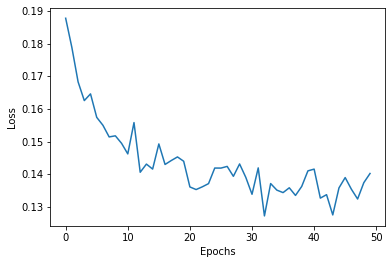

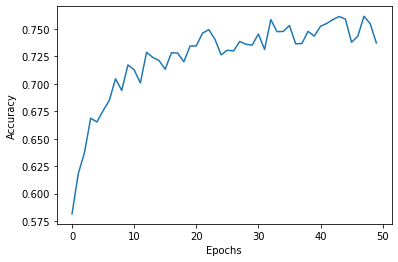

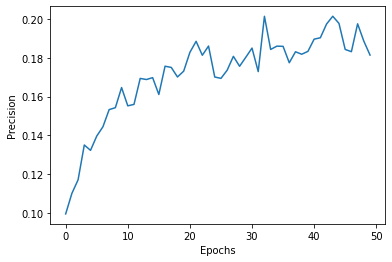

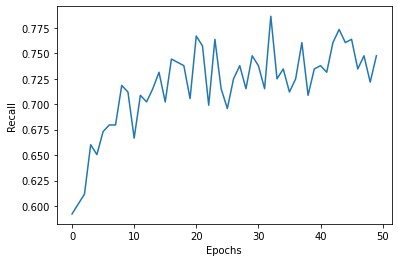

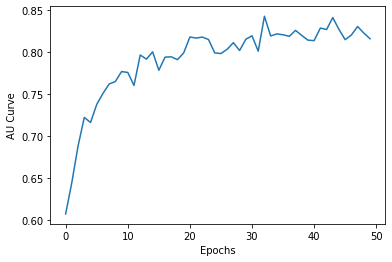

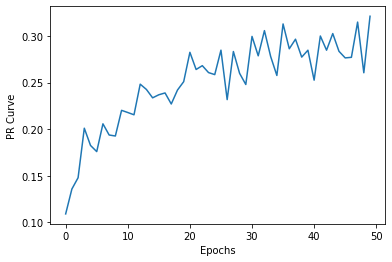

In [ ]:
mapp = {'loss':'Loss' , 'accuracy' : 'Accuracy', 'precision':'Precision','recall':'Recall','auc':'AU Curve','prc':'PR Curve'}
plot_curves(hist,mapp)

# XLNet Model

## Data Splitting

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
X_train,y_train = bert_encode(train_data,60)
X_test,y_test = bert_encode(test_data,60)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


## Loading preprocessor and encoder

In [ ]:
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

## Loading Model

In [ ]:
xlnet = create_model_xlnet(xlnet_model)
xlnet.summary()

/usr/local/lib/python3.7/dist-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassific

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_inputs (InputLayer)    [(None, 60)]              0         
                                                                 
 tfxl_net_model_4 (TFXLNetMo  TFXLNetModelOutput(last_  116718336
 del)                        hidden_state=(None, 60,             
                             768),                               
                              mems=((60, None, 768),             
                              (60, None, 768),                   
                              (60, None, 768),                   
                              (60, None, 768),                   
                              (60, None, 768),                   
                              (60, None, 768),                   
                              (60, None, 768),                   
                              (60, None, 768),             

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


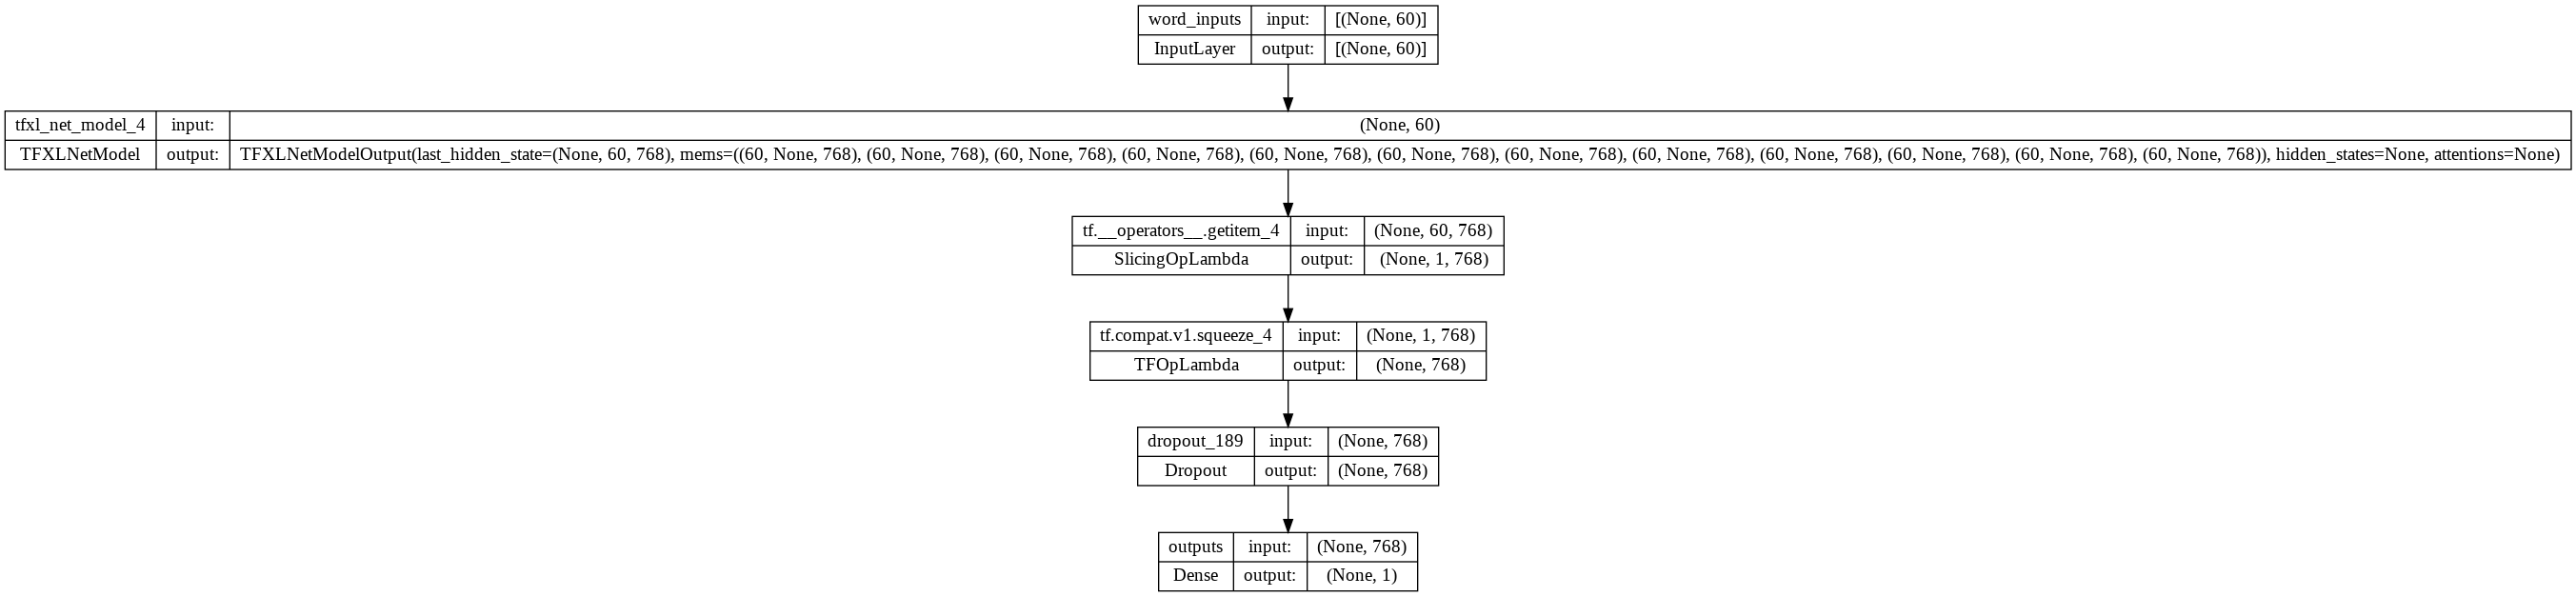

In [ ]:
plot_model(xlnet, expand_nested=True, show_shapes=True)

## Model Training

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
history_xl = xlnet.fit(X_train,np.array(train_data['Miso']), epochs=50,batch_size=16,class_weight=class_weight)

Epoch 1/50


267/267 [==============================] - 87s 259ms/step - loss: 0.8789 - tp: 145.0000 - fp: 1814.0000 - tn: 2140.0000 - fn: 164.0000 - accuracy: 0.5360 - precision: 0.0740 - recall: 0.4693 - auc: 0.5101 - prc: 0.0745
Epoch 2/50
267/267 [==============================] - 69s 258ms/step - loss: 0.7467 - tp: 144.0000 - fp: 1776.0000 - tn: 2178.0000 - fn: 165.0000 - accuracy: 0.5447 - precision: 0.0750 - recall: 0.4660 - auc: 0.5033 - prc: 0.0718
Epoch 3/50
267/267 [==============================] - 69s 258ms/step - loss: 0.7663 - tp: 143.0000 - fp: 2032.0000 - tn: 1922.0000 - fn: 166.0000 - accuracy: 0.4844 - precision: 0.0657 - recall: 0.4628 - auc: 0.4697 - prc: 0.0665
Epoch 4/50
267/267 [==============================] - 69s 258ms/step - loss: 0.7634 - tp: 145.0000 - fp: 1873.0000 - tn: 2081.0000 - fn: 164.0000 - accuracy: 0.5222 - precision: 0.0719 - recall: 0.4693 - auc: 0.4812 - prc: 0.0673
Epoch 5/50
267/267 [==============================] - 69s 259ms/step - loss: 0.7502 - tp: 1

## Model Saving

In [ ]:
# xlnet.save('/content/drive/MyDrive/Projects/Superprof_Projects/Dhruba/XLNET_model.h5')
pickle.dump(history_xl.history,open('/content/drive/MyDrive/Projects/Superprof_Projects/Dhruba/XLNET_history.pkl', 'wb'))

## Results and Plots

In [ ]:
mdl = xlnet 

In [ ]:
# mdl = tf.keras.models.load_model(('/content/drive/MyDrive/Projects/Superprof_Projects/Dhruba/XLNET_model.h5'),
#                                  custom_objects={'KerasLayer':hub.KerasLayer})
hist = pickle.load(open('/content/drive/MyDrive/Projects/Superprof_Projects/Dhruba/XLNET_history.pkl', 'rb'))

### Prediction on Test data

In [ ]:
y_pred = mdl.predict(X_test).flatten()
y_predicted = np.where(y_pred>0.5,1,0)

34/34 [==============================] - 7s 150ms/step


### Classification Report

In [ ]:
target_names = ['Non Gendered', 'Gendered']
print(classification_report(np.array(test_data['Miso']), y_predicted, target_names=target_names))

              precision    recall  f1-score   support

Non Gendered       0.95      0.94      0.94       993
    Gendered       0.28      0.32      0.29        73

    accuracy                           0.90      1066
   macro avg       0.61      0.63      0.62      1066
weighted avg       0.90      0.90      0.90      1066



### Loss and Accuracy Plot

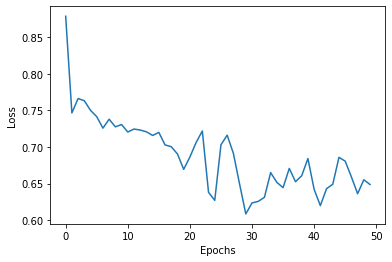

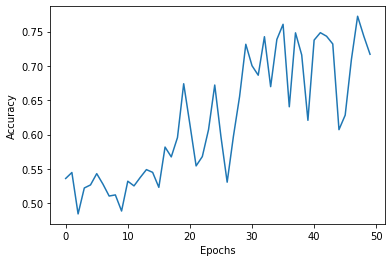

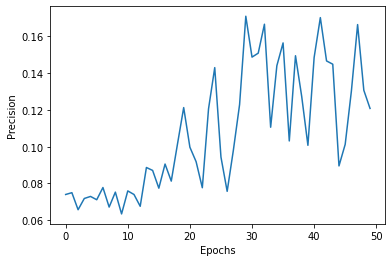

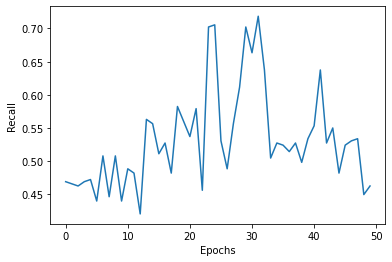

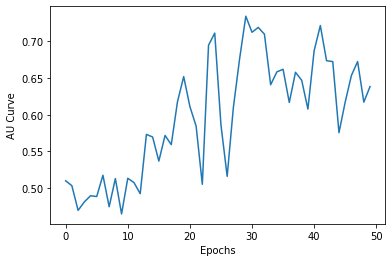

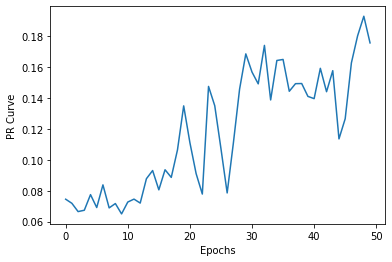

In [ ]:
mapp = {'loss':'Loss' , 'accuracy' : 'Accuracy', 'precision':'Precision','recall':'Recall','auc':'AU Curve','prc':'PR Curve'}
plot_curves(hist,mapp)